In [1]:
import warnings
from arch import arch_model
import pandas as pd
import numpy as np
import tqdm
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm
import statsmodels.tsa.api as smt
import matplotlib.pyplot as plt
from scipy.stats import boxcox
from math import sqrt
import matplotlib.pyplot as plt
%matplotlib inline
warnings.filterwarnings('ignore')

In [2]:
def test_stationarity(timeseries):
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=[
                         'Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
    for [key, value] in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)


def tsplot(y, lags=None, figsize=(14, 8), style='bmh'):
    test_stationarity(y)
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):
        plt.figure(figsize=figsize)
        layout = (5, 1)
        ts_ax = plt.subplot2grid(layout, (0, 0), rowspan=2)
        acf_ax = plt.subplot2grid(layout, (2, 0))
        pacf_ax = plt.subplot2grid(layout, (3, 0))
        qq_ax = plt.subplot2grid(layout, (4, 0))

        y.plot(ax=ts_ax, color='blue', label='Or')
        ts_ax.set_title('Original')

        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.05)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.05)
        sm.qqplot(y, line='s', ax=qq_ax)

        plt.tight_layout()
    return


def _get_best_model(TS):
    best_aic = np.inf
    best_order = None
    best_mdl = None

    for i in range(5):
        for d in range(5):
            for j in range(5):
                try:
                    tmp_mdl = smt.ARIMA(series_train, order=(
                        i, d, j)).fit(method='mle', trend='nc')
                    tmp_aic = tmp_mdl.aic
                    if tmp_aic < best_aic:
                        best_aic = tmp_aic
                        best_order = (i, d, j)
                        best_mdl = tmp_mdl
                except:
                    continue

    print('aic: {:6.5f} | order: {}'.format(best_aic, best_order))
    return best_aic, best_order, best_mdl


def RMSE():
    return round(mean_squared_error(series_test, best_mdl.predict(1, len(series_test)), squared=False), 4)

In [3]:
series = pd.read_csv(
    "../015 Временные ряды, общая теория/Series/monthly-sales-of-company-x-jan-6.csv")['Count']

In [4]:
series = boxcox(series, 0)
series = series[1:] - series[:-1]
series = series[14:] - series[:-14]

Results of Dickey-Fuller Test:
Test Statistic                 -5.327434
p-value                         0.000005
#Lags Used                      9.000000
Number of Observations Used    52.000000
Critical Value (1%)            -3.562879
Critical Value (5%)            -2.918973
Critical Value (10%)           -2.597393
dtype: float64


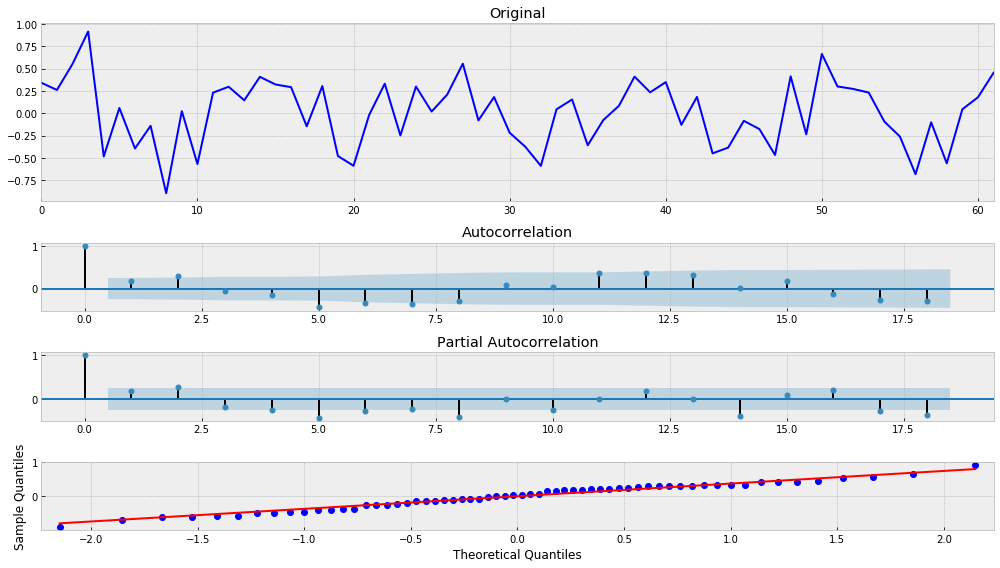

In [5]:
tsplot(series)

In [6]:
series_train, series_test = series[:40], series[40:]

### ARIMA

In [7]:
aic, order, best_mdl = _get_best_model(series_train)

aic: 28.08350 | order: (3, 0, 2)


Results of Dickey-Fuller Test:
Test Statistic                 -4.924396
p-value                         0.000031
#Lags Used                      1.000000
Number of Observations Used    38.000000
Critical Value (1%)            -3.615509
Critical Value (5%)            -2.941262
Critical Value (10%)           -2.609200
dtype: float64


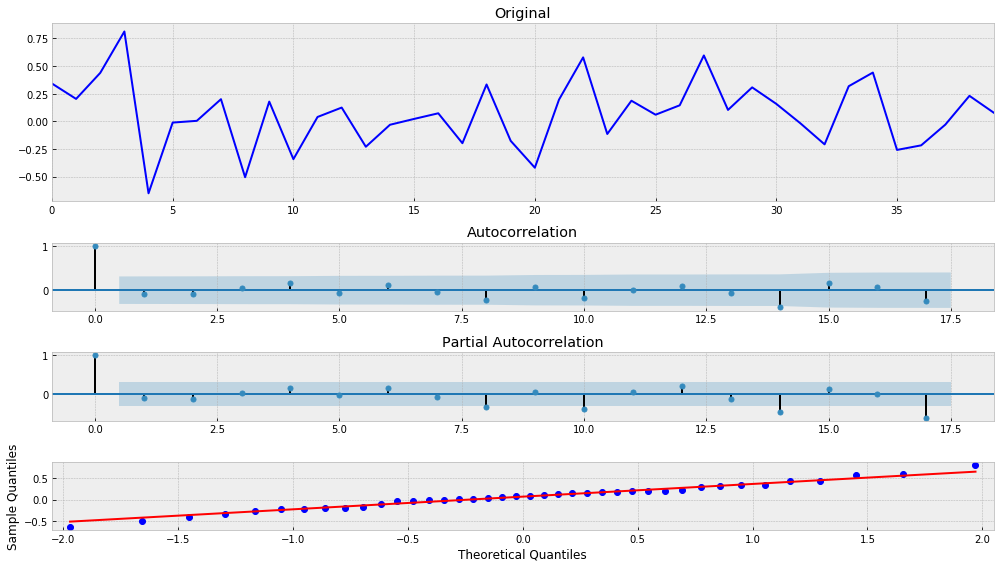

In [8]:
tsplot(best_mdl.resid)

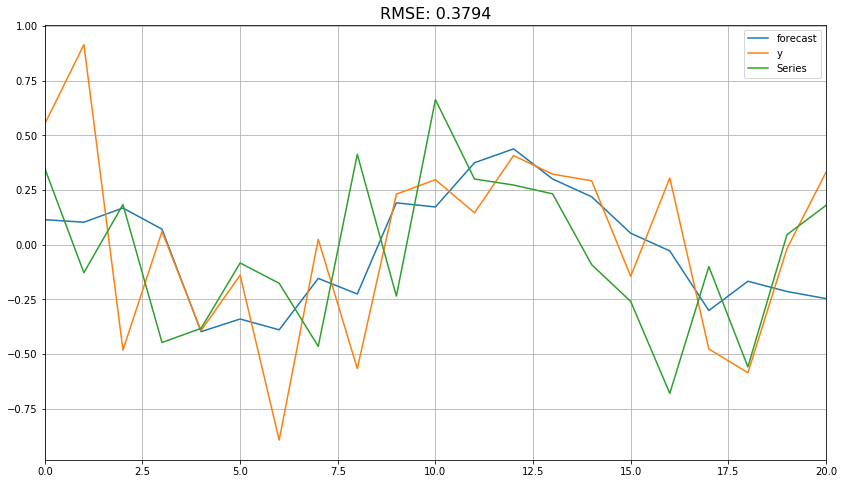

In [9]:
plt.figure(figsize=(14, 8))
ax = plt.axes()
best_mdl.plot_predict(2, len(series_test), ax=ax)
plt.plot(series_test, label='Series')
plt.title(f"RMSE: {RMSE()}", fontsize=16)
plt.legend()
plt.grid()
plt.show()

### GARCH

In [10]:
am = arch_model(series_train, p=3, o=0, q=2, dist='StudentsT')
res = am.fit(update_freq=5, disp='off')
print(res.summary())

                        Constant Mean - GARCH Model Results                         
Dep. Variable:                            y   R-squared:                      -0.000
Mean Model:                   Constant Mean   Adj. R-squared:                 -0.000
Vol Model:                            GARCH   Log-Likelihood:               -16.2320
Distribution:      Standardized Student's t   AIC:                           48.4639
Method:                  Maximum Likelihood   BIC:                           61.9750
                                              No. Observations:                   40
Date:                      Mon, May 25 2020   Df Residuals:                       32
Time:                              19:51:01   Df Model:                            8
                                 Mean Model                                
                 coef    std err          t      P>|t|     95.0% Conf. Int.
---------------------------------------------------------------------------
mu     

Results of Dickey-Fuller Test:
Test Statistic                -5.758917e+00
p-value                        5.732832e-07
#Lags Used                     7.000000e+00
Number of Observations Used    3.200000e+01
Critical Value (1%)           -3.653520e+00
Critical Value (5%)           -2.957219e+00
Critical Value (10%)          -2.617588e+00
dtype: float64


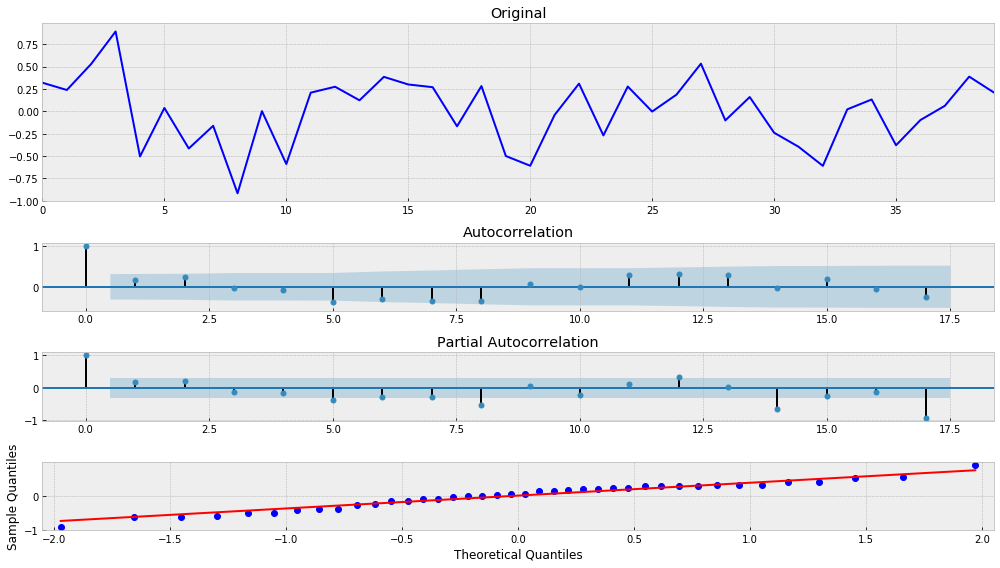

In [11]:
tsplot(res.resid)